# Weak form loss tutorial

This tutorial will walk through how to learn a continuous time model for an ODE from the weak form of the governing equations. Note that the weak form loss function can be used to training any continuous time model of an ODE. In this tutorial we will use a generic fully-connected neural network. 

The weakformghnn package provides a squared weak form loss function to be used to efficiently learn an ODE.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math 
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from weakformghnn import weak_form_loss, gauss_rbf
torch.random.manual_seed(42)

## Generating data

Let's generate some training data. We will simulate a duffing oscillator as it decays towards one of it's two regions of local stability.

Text(0, 0.5, 'y')

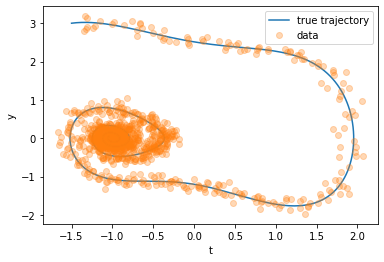

In [2]:
t = torch.linspace(0., 20., 1000)
class DuffingODE(nn.Module):
    """ Duffing oscilator with friction
    """
    def __init__(self):
        super(DuffingODE, self).__init__()
        self.xl = torch.tensor([-2., -2.])
        self.xu = torch.tensor([2., 2.])
        self.NDIM = 2
        self._J = torch.tensor([[0., 1.], [-1., 0.]])
        self._R = 3.5*torch.Tensor([[0., 0.], [0., -0.1]])
    def H(self, x):
        x2 = x[:, 1]
        x1 = x[:, 0]
        return 0.5*x2.pow(2) - 0.5*x1.pow(2) + 0.25*x1.pow(4)
    def ode(self, t, x):
        with torch.enable_grad():
            if not x.requires_grad:
                x.requires_grad = True
            grad_h = torch.autograd.grad(
                self.H(x).sum(), x, retain_graph=False)[0]
            return torch.mm(grad_h, self._J.T) + torch.mm(grad_h, self._R.T)
    def forward(self, t, x):
        in_shape = x.shape
        x = x.reshape(-1, self.NDIM)
        return self.ode(t, x).reshape(in_shape)

ode = DuffingODE()
y = odeint(ode, torch.tensor([[-1.5,3.0]]), t).squeeze(1)
y_meas = y + torch.randn(y.shape)*0.1

plt.plot(y[:,0], y[:,1], label='true trajectory')
plt.plot(y_meas[:,0], y_meas[:,1],'o',alpha=0.3, label='data')
plt.legend()
plt.xlabel('t')
plt.ylabel('y')

## Defining an ODE model

Let's now define a neural network model for an autonomous ODE.

In [3]:
class ODEModel(nn.Module):
    def __init__(self, num_inputs, nhidden):
        super(ODEModel, self).__init__()
        self.num_inputs = num_inputs
        self.mlp = nn.Sequential(
            nn.Linear(num_inputs, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, num_inputs)
        )

    def forward(self, t, x):
        bs = x.shape[:-1] # reshape to handle multi-dim batches
        return self.mlp(x.reshape(-1,self.num_inputs)).reshape(*bs, self.num_inputs)


## Training the ODE with weak form loss


First we define a helper function for sampling data

In [4]:
def sample_data(t, y, batch_time_int, batch_size):
    """ Draws batch_size samples from y and t with an integration time of batch_time_int
        Assumes all points are evenly spaced 
    inputs:
        t < tensor(num_t,) > 
        y < tensor(num_t, num_start_times, NDIM)  > 
        batch_time_int < int > 
        batch_size < int > 
    outputs:
        t_data < tensor(batch_time_int) > 
        y_data < tensor(batch_time_int, batch_size, NDIM) > 
    """
    num_t = len(t)
    t_data = t[:batch_time_int]
    batch_idx = np.random.choice(np.arange(num_t - batch_time_int + 1),
                                 batch_size, replace=False)
    run_idx = np.random.choice(np.arange(y.shape[1]), batch_size, replace=True)
    y_data = torch.stack(
        [y[batch_idx[i]:batch_idx[i] + batch_time_int, run_idx[i]]
            for i in range(len(batch_idx))], dim=1)
    return t_data, y_data

We will run this example on GPU if it is available

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Running on: {}".format(device))

Running on: cuda:0


We will use 400 radial basis functions with a shape parameter of 10 in each integration time window.

In [6]:
epoch = 200
model = ODEModel(2, 200)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-1)
rbf_ep = 10.0
model.to(device)
for ep in range(1,epoch+1):
    optimizer.zero_grad()
    t_sample, y_sample = sample_data(t, y_meas.unsqueeze(1), 500, 80)
    t_sample = t_sample.to(device)
    y_sample = y_sample.to(device)
    dydt_pred = model(t_sample, y_sample)
    c = torch.linspace(t_sample[0], t_sample[-1], 400, device=device)
    psi, psi_dot = gauss_rbf(t_sample, c, rbf_ep)
    loss = weak_form_loss(dydt_pred.transpose(1, 0), y_sample.transpose(1, 0), 
                          t_sample, psi, psi_dot) 
    if ep % 50 == 0:
        print("Epoch: {:04d}, loss: {:.2f}".format(ep,loss.item()))
    loss.backward()
    optimizer.step()


Epoch: 0050, loss: 1.53
Epoch: 0100, loss: 1.16
Epoch: 0150, loss: 1.11
Epoch: 0200, loss: 1.07


## Visualizing the results 

We see we were able to learn a model for the ODE which reproduces the data generating trajectory well.

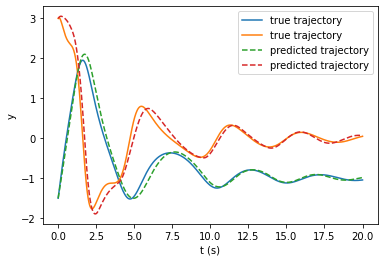

In [7]:
model.to('cpu')
y_pred = odeint(model, y[0],t)
with torch.no_grad():
    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t, y, label='true trajectory')
    ax.plot(t, y_pred,'--', label='predicted trajectory')
    ax.set_xlabel('t (s)')
    ax.set_ylabel('y')
    plt.legend()
    plt.pause(1/60) 